# display masks

In [3]:
import os
import os.path as osp
import numpy as np
import torch
from PIL import Image
from colormap import rgb2hex

In [4]:
import tqdm

In [5]:

class EndovisDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned

        self.sub_folders = list(sorted(os.listdir(root)))
        self.sub_sub_folder = 'left_frames'
        self.sub_sub_folder_masks = 'ground_truth/TypeSegmentationRescaled'
        self.imgs = []
        self.masks = []
        for sf in self.sub_folders[:-1]:

            list_files = list(sorted(os.listdir(osp.join(root, sf, self.sub_sub_folder))))
            list_path = [osp.join(root, sf, self.sub_sub_folder, file) for file in list_files]

            list_masks = list(sorted(os.listdir(osp.join(root, sf, self.sub_sub_folder_masks))))
            list_path_masks = [osp.join(root, sf, self.sub_sub_folder_masks, file) for file in list_masks]

            self.imgs += list_path
            self.masks += list_path_masks

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        mask_hex = np.apply_along_axis(lambda x : rgb2hex(x[0], x[1], x[2]), axis=-1, arr = mask.astype(np.int64) )  
        # instances are encoded as different colors
        obj_ids = np.unique(mask_hex)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # generate as puch masks as objects cf notebook
        masks = mask_hex == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin >= xmax or ymin >= ymax:
                continue
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [6]:
import yaml

with open("./config/config_endovis.yml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    print("Read successful")
print(config)

Read successful
{'model_name': 'fine_tuned_m_r_cnn_0', 'tasks': ['bbox', 'segm'], 'heads': {'bbox': 'fastrcnn', 'segm': 'maskrcnn', 'class': None}, 'device': 'cuda', 'distributed_training': True, 'num_classes': 2, 'hidden_layer_segm': 256, 'loss_fn': None, 'dataset': 'endovis', 'train_ds': '/data/user/DATA_SSD1/__adri/endovis/Test', 'val_ds': '/data/user/DATA_SSD1/__adri/endovis/Test', 'weights_path': '/data/user/DATA_SSD1/__adri/weights/', 'batch_size': 6, 'epochs': 40, 'patience': 3, 'checkpoint_frequency': 2, 'train_steps': None, 'val_steps': None}


## train fn

In [7]:
import sys

In [8]:
sys.path

['/coding_linux20/encov_torch/nn_training/src/nn',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython']

In [9]:
sys.path.append('/coding_linux20/encov_torch/nn_training')

In [10]:
from archs.data_load import *
from archs.helper import *
#from src.nn.archs.segmentation import *
from archs.trainer import Trainer

from models.models import *

import references.detection.utils as utils

from src.tools.helper import log_config

In [11]:
device = torch.device(config['device'])

# use our dataset and defined transformations
if config['dataset'] == 'pennpudanped':
    dataset = PennFudanDataset(config['train_ds'], get_transform(train=True))
    dataset_test = PennFudanDataset(config['val_ds'], get_transform(train=False))
    
if config['dataset'] == 'endovis':
    dataset = EndovisDataset(config['train_ds'], get_transform(train=True))
    dataset_test = EndovisDataset(config['val_ds'], get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=config['batch_size'], shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
nn = get_model_instance(config['num_classes'], config['hidden_layer_segm'] ,config['heads'])
#nn = get_model_instance_segmentation(2)

# # move model to the right device
# model.to(device)

# construct an optimizer
params = [p for p in nn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

## use data loader to display a mask

In [12]:
training_loader_iter = iter(train_dataloader)

In [13]:
x, y = next(training_loader_iter)

### Examine x

In [17]:
len(x)

6

In [21]:
torch.unique(x[0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [22]:
x

(tensor([[[15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          ...,
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15]],
 
         [[15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          ...,
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15]],
 
         [[15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          ...,
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15]]], dtype=torch.uint8),
 tensor([[[15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          ...,
          [15, 15, 15,  ..., 1

### y

In [14]:
len(y)

6

In [15]:
y[0].keys()

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])

In [29]:
torch.unique(y[0]['masks'])

tensor([0, 1], dtype=torch.uint8)

In [30]:
import cv2
import numpy as np
import random
import torch
from colormap import hex2rgb

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]




# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))


In [60]:

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        print('*******image ', image.shape)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        print('*******image ', image.shape)
        # apply mask on the image
        print('*******red_map ', red_map.shape)
        print('*******segmentation_map ', segmentation_map.shape)
        print('*******image ', image.shape)
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        print('rrr', image)
        print('rrr', boxes[i][0])
        print('rrr', boxes[i][1])
        
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return np.array(image)

In [61]:
boxes_ = y[0]['boxes'].tolist()

In [67]:
boxes = [[(int(box[0]),int(box[1])), (int(box[2]),int(box[3]))] for box in boxes_]

In [68]:
boxes

[[(329, 735), (361, 780)], [(1015, 643), (1589, 874)]]

In [69]:
labels = ['xxx'] * len(boxes)

In [70]:
img = np.moveaxis(x[0].numpy(), 0, -1)

In [71]:
img = draw_segmentation_map(img, y[0]['masks'], boxes, labels)

*******image  (1080, 1920, 3)
*******image  (1080, 1920, 3)
*******red_map  (1080, 1920)
*******segmentation_map  (1080, 1920, 3)
*******image  (1080, 1920, 3)
rrr [[[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 ...

 [[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]]
rrr (329, 735)
rrr (361, 780)
*******image  (1080, 1920, 3)
*******image  (1080, 1920, 3)
*******red_map  (1080, 1920)
*******segmentation_map  (1080, 1920, 3)
*******image  (1080, 1920, 3)
rrr [[[15 15 15]
  [15 15 15]
  [15 15 15]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[15 15 15]
  [15 15 15]
  [15 15

In [73]:
import matplotlib.pyplot as plt

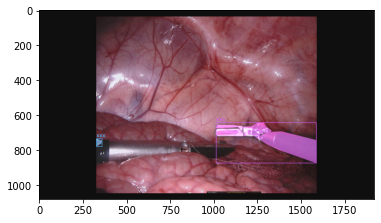

In [74]:
plt.imshow(img)

# display model type

In [1]:
from models import models

In [7]:
import torchvision
import torch

In [3]:
heads =  {'bbox': 'fastrcnn', 'segm': 'maskrcnn'}

In [5]:
nn = models.get_model_instance(2, 256 , heads)

In [8]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [26]:
_get_iou_types(nn)

['bbox', 'segm']